<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Xanda Schofield](https://www.cs.hmc.edu/~xanda) for the 2022 Text Analysis Pedagogy Institute, with support from the [National Endowment for the Humanities](https://neh.gov), [JSTOR Labs](https://labs.jstor.org/), and [University of Arizona Libraries](https://new.library.arizona.edu/).

For questions/comments/improvements, email xanda@cs.hmc.edu.<br />
____

# Text Data Curation 2

This is lesson 2 of 3 in the educational series on Text Data Curation. This notebook is intended to introduce the basics of treating text documents as data and how to store and filter those documents.

**Audience:** `Learners` / `Researchers`

**Use case:** [`How-To`](https://constellate.org/docs/documentation-categories#howtoproblemoriented) 

**Difficulty:** `Intermediate`
Assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.

**Completion time:** `90 minutes`

**Knowledge Required:** 
```
* Python basics (variables, flow control, functions, lists, dictionaries)
* How Python libraries work (installation and imports)
```

**Knowledge Recommended:**
```
* Basic file operations (open, close, read, write)
* How text is stored on computers
```

**Learning Objectives:**
After this lesson, learners will be able to:
```
1. Describe and implement an XXXX for XXXX
2. Convert XXXX into XXXX for the purpose of XXXX
3. Develop a workflow in order to XXXX
4. Be familiar with XXXXX resources for pursuing the topic
```
**Research Pipeline:**
```
1. Research steps before this notebook
2. **The skills in this notebook**
3. Steps after this notebook
4. Final steps
```
___

# Required Python Libraries
`List out any libraries used and what they are used for`
* [Tesseract](https://tesseract-ocr.github.io/) for performing [optical character recognition](https://docs.constellate.org/key-terms/#ocr).
* [Pandas](https://pandas.pydata.org/) for manipulating and cleaning data.
* [Pdf2image](https://pdf2image.readthedocs.io/en/latest/) for converting pdf files into image files.

## Install Required Libraries

In [22]:
### Install Libraries ###

# Get spacy and the English web data language model
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [27]:
### Import Libraries ###
# Built into Python
from collections import Counter
import re

# External imports
from matplotlib import pyplot as plt
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Required Data

`List out the data sources, including their formats and a few sentences describing the data. Include a link to the data source description, if possible.`

**Data Format:** 
* Python archive

**Data Source:**
* [20 Newsgroups via Scikit-Learn](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)

**Data Quality/Bias:**
This dataset is originally made from retrieving 1000 messages each from 20 different Usenet newsgroups. Because of cross-posting between newsgroups and repetition, the original dataset is almost never used; this version of the dataset is trimmed to ~18,000 messages across the newsgroups. While the utilities for the dataset allow you to remove headers, quotes, and footers/signature lines, the dataset still contains a significant amount of noise, as well as some views and statements that some may find disturbing or offensive. (If you're not familiar with Usenet, it's worth thinking of this as having a similar content to Reddit, except with less moderation.)


## Download Required Data

In [2]:
### Grab just the space messages to start
newsgroup_data = fetch_20newsgroups(categories=['sci.space'])

# Introduction

In the previous lesson, we looked at the metadata of a Spanish poems dataset and explored ways to store and explore that data, noticing things about encodings, author frequency, and duplication. In this section, we're going to look more at unstructured text directly and how we can pre-process that text.

# Lesson

## Style tips for writing your lesson body

In [3]:
def data_by_idx(idx, full=False, n_chars=1000, data=newsgroup_data.data):
    if full:
        return data[idx]
    else:
        return data[idx][:n_chars] + ' ... [ {} more characters ]'.format(len(data[idx]) - n_chars)

In [4]:
for i in range(10):
    print(data_by_idx(i))

From: henry@zoo.toronto.edu (Henry Spencer)
Subject: Re: japanese moon landing?
Organization: U of Toronto Zoology
Lines: 21

In article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:
>> there is no such thing as a stable lunar orbit
>
>Is it right??? That is new stuff for me. So it means that  you just can 
>not put a sattellite around around the Moon for too long because its 
>orbit will be unstable??? If so, what is the reason??? Is that because 
>the combined gravitacional atraction of the Sun,Moon and Earth 
>that does not provide a stable  orbit around the Moon???

Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations 

In [5]:
def remove_quotes_a(doc):
    # delete lines that start with > or |>
    lines = doc.split('\n')
    lines_to_keep = [l for l in lines if not (l.startswith('>') or l.startswith('|>'))]
    return '\n'.join(lines_to_keep)


def remove_quotes_b(doc):
    # replace a sequence of lines that starts with > or |> with one new line
    # I use pythex.org to troubleshoot these for Python
    return re.sub(r'\n(\|?>+[^\n]*\n)+', '\n', doc)

In [6]:
for i in range(10):
    print(remove_quotes_a(data_by_idx(i, full=True)))

From: henry@zoo.toronto.edu (Henry Spencer)
Subject: Re: japanese moon landing?
Organization: U of Toronto Zoology
Lines: 21

In article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:

Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon.
-- 
All work is one man's work.             | Henry Spencer @ U of Toronto Zoology
                    - Kipling           |  henry@zoo.toronto.edu  utzoo!henry

From: henry@zoo.toronto.edu (Hen

In [7]:
# Using a new name to avoid conflicts
clean_newsgroup_data = fetch_20newsgroups(categories=['sci.space'], remove=('headers', 'footers', 'quotes'))

Text(0.5, 0, 'Word count')

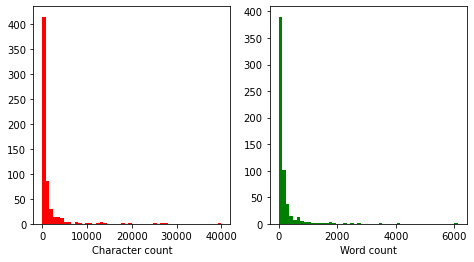

In [8]:
# Let's look at some histograms and see if there are any concerning outliers
char_counts = np.array([len(d) for d in clean_newsgroup_data.data])
word_counts = np.array([len(d.split()) for d in clean_newsgroup_data.data])
# can we keep track of how many lines are in each document as well?

# make a figure 3x as wide as it is tall
# this will allow us 3 subplots in one plot!
plt.figure(figsize=(12, 4))

# plot 1: character counts
plt.subplot(1, 3, 1) # this says this is the first of the plots in 1 row and 3 columns
plt.hist(x=char_counts, bins=50, color='red', label='Characters')
plt.xlabel("Character count")

# plot 2: word counts
plt.subplot(1, 3, 2) 
plt.hist(x=word_counts, bins=50, color='green', label='Words')
plt.xlabel("Word count")

# how would we make the third plot a blue plot of the number of lines in each?

In [9]:
def clean_text(text):
    text = re.sub(r'Archive-name: [^\n]*\n', '', text)  # remove header lines
    text = re.sub(r'Last-modified: [^\n]*\n', '', text) # remove header lines
    # how would you replace digits with a '#' symbol?
    return text

In [10]:
print(clean_text(data_by_idx(499, full=True, data=clean_newsgroup_data.data)))


PLANETARY PROBES - HISTORICAL MISSIONS

    This section was lightly adapted from an original posting by Larry Klaes
    (klaes@verga.enet.dec.com), mostly minor formatting changes. Matthew
    Wiener (weemba@libra.wistar.upenn.edu) contributed the section on
    Voyager, and the section on Sakigake was obtained from ISAS material
    posted by Yoshiro Yamada (yamada@yscvax.ysc.go.jp).

US PLANETARY MISSIONS


    MARINER (VENUS, MARS, & MERCURY FLYBYS AND ORBITERS)

    MARINER 1, the first U.S. attempt to send a spacecraft to Venus, failed
    minutes after launch in 1962. The guidance instructions from the ground
    stopped reaching the rocket due to a problem with its antenna, so the
    onboard computer took control. However, there turned out to be a bug in
    the guidance software, and the rocket promptly went off course, so the
    Range Safety Officer destroyed it. Although the bug is sometimes claimed
    to have been an incorrect FORTRAN DO statement, it was actually a
   

In [11]:
cv = CountVectorizer(stop_words='english')
# can we adjust this to clean the data?
count_data = cv.fit_transform([t for t in clean_newsgroup_data.data])

print("Count matrix dimensions (documents x features):", count_data.shape)
print(count_data)

Count matrix dimensions (documents x features): (593, 13273)
  (0, 7607)	2
  (0, 10605)	1
  (0, 8361)	1
  (0, 5588)	2
  (0, 10072)	1
  (0, 8747)	1
  (0, 3690)	1
  (0, 10528)	1
  (0, 3761)	1
  (0, 8162)	1
  (0, 8753)	2
  (0, 1857)	1
  (0, 8187)	1
  (0, 3016)	1
  (0, 8514)	1
  (0, 8076)	1
  (0, 7280)	1
  (0, 3960)	1
  (0, 9375)	1
  (0, 11375)	1
  (0, 8167)	3
  (0, 5945)	2
  (0, 5293)	2
  (0, 9338)	1
  (0, 7740)	1
  :	:
  (592, 2418)	1
  (592, 7363)	1
  (592, 3577)	1
  (592, 3387)	1
  (592, 3506)	2
  (592, 3026)	3
  (592, 2174)	1
  (592, 5292)	1
  (592, 8640)	1
  (592, 1586)	1
  (592, 2209)	1
  (592, 4952)	2
  (592, 2172)	1
  (592, 2834)	1
  (592, 2416)	1
  (592, 7357)	1
  (592, 11379)	1
  (592, 1769)	2
  (592, 618)	1
  (592, 13226)	1
  (592, 7462)	1
  (592, 1915)	1
  (592, 5594)	1
  (592, 1206)	1
  (592, 3704)	1


In [14]:
features = cv.get_feature_names()
# note: soon to be deprecated, will be replaced with cv.get_feature_names_out
print(', '.join(features))

00, 000, 0000, 00000, 000000, 000062david42, 00041032, 0004136, 0004246, 0004422, 00044513, 0004847546, 0005, 00090711, 0012, 0018, 0020, 0022, 0028, 0029, 0033, 0034, 006, 0065, 0098, 01, 01826, 018b, 02, 020359, 02115, 02138, 02139, 02178, 023b, 0245, 03, 030, 0300, 034, 034101, 04, 040, 04110, 041493003715, 045, 05, 050, 0500, 0545, 054589e, 058, 06, 060, 0605, 06111, 06179397, 06487, 067, 0674, 0695, 07, 070, 0739, 074, 08, 08080, 0820, 08540, 08544, 0856e16, 0865, 09, 0941, 0970, 0971, 0988, 0km, 0w, 10, 100, 1000, 10000, 1000r, 10019, 10020, 10022, 10023, 10036, 100k, 100km, 100nm, 100th, 101, 10158, 102, 10281, 1030, 104, 1044, 10460, 1049, 105, 105366, 1059, 105m, 106, 107, 1079, 1084, 109125, 109147, 10bps, 10cm, 10km, 10kw, 10m, 11, 110, 1100, 110m, 111, 111s, 112, 113, 115, 1150, 1151, 115m, 1163, 1179, 11888, 119, 1190, 119th, 12, 120, 1200, 1200mi, 1204, 1207, 121, 1212, 122, 1220, 1222, 122nd, 1234, 1238, 125, 12607, 12649, 12770, 128, 129, 1290, 1292, 12km, 12m, 13, 130,

In [15]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'wherein', 'latter', 'part', 'about', 'perhaps', 'the', 'he', 'upon', 'no', 'becomes', 'cant', 'but', 'so', 'hasnt', 'ours', 'former', 'your', 'whom', 'one', 'de', 'somehow', 'me', 'never', 'twelve', 'seem', 'something', 'well', 'his', 'still', 'beforehand', 'cannot', 'under', 'herein', 'thence', 'call', 'side', 'somewhere', 'us', 'towards', 'very', 'while', 'front', 'besides', 'anyone', 'some', 'twenty', 'nevertheless', 'thereafter', 'every', 'always', 'everyone', 'ourselves', 'who', 'find', 'whatever', 'whole', 'yourselves', 'another', 'can', 'five', 'sixty', 'would', 'much', 'get', 'third', 'they', 'should', 'by', 'formerly', 'although', 'that', 'whoever', 'otherwise', 'nowhere', 'further', 'him', 'name', 'done', 'around', 'if', 'often', 'thereby', 'become', 'therein', 'in', 'however', 'during', 'hereby', 'nor', 'herself', 'see', 'back', 'mine', 'all', 'could', 'inc', 'less', 'made', 'most', 'hereafter', 'fifteen', 'nobody', 'everything', 'were', 'six', 'up', 'elsewhere',

In [16]:
# this is a simpler tokenization option: one or more (+) letter characters (\w)
retok = RegexpTokenizer(r'[A-Za-z]+')

def tokenize_words(input_string):
    return retok.tokenize(input_string.lower())

clean_cv = CountVectorizer(
    tokenizer=tokenize_words,    # use this function to split text
    min_df=10,                    # minimum # of documents to show up in
    max_df=0.3)                  # maximum proportion of documents to show up in
# can we adjust this to clean the data?
clean_count_data = clean_cv.fit_transform([t for t in clean_newsgroup_data.data])

# we should have many fewer features
print("New count matrix dimensions (documents x features):", clean_count_data.shape)

New count matrix dimensions (documents x features): (593, 1148)


In [17]:
clean_features = clean_cv.get_feature_names()

print("Stoplist:", ', '.join(clean_cv.stop_words_))

for test_word in ['the', 'is', 'was', 'could', 'isn', 'msu', 'milky way']:
    print(test_word, "in features:", test_word in clean_features)

Stoplist: household, kk, waterwood, contains, doees, determinations, waterloo, chimpanzee, admit, sron, trading, airport, walked, solicitation, nichols, tpa, cyclically, ubn, demonstarted, carrot, dcx, hazards, assess, mariatta, nearly, magnetism, glennc, puffs, spool, hurdles, ariadne, salisbury, maps, penalties, davies, capitalist, cylinders, butter, independent, flattering, vega, umbilical, blvd, lambeth, songs, barrel, marco, makeup, eaten, suns, mrose, brasil, sponsored, gummint, ips, sentence, liked, nationalist, ilmenite, inquiring, disadvantages, daniel, ulysses, whew, seasons, lindbergh, art, oneil, std, malfunction, ne, seconde, decades, dailey, profiting, supercar, reluctant, coverage, diagram, purposes, fruitless, instrumentation, benefits, replaced, keys, radios, photograph, plotter, speulate, fell, practise, ties, almanac, ventures, claim, advising, applicable, expressly, horizontially, mad, datum, overall, slips, orleans, dimensional, mostest, modular, bankst, indigenous

In [18]:
tokenized_docs = [tokenize_words(clean_text(d)) for d in clean_newsgroup_data.data]

bigram_finder = BigramCollocationFinder.from_documents(tokenized_docs)
bigram_finder.apply_freq_filter(5)
for w1, w2 in bigram_finder.nbest(BigramAssocMeasures.pmi, 100):
    print(w1, w2)

wales larrison
hong kong
carl sagan
dani eder
dn volts
mcwilliams wk
topex poseidon
cl msu
kjenks gothamcity
tmp rcst
cape canaveral
chrisj emx
cd rom
mystery grows
zoo toronto
ingress egress
isu isunet
gao nsiad
los angeles
nssdca gsfc
willmann bell
baalke kelvin
pasadena calif
ken jenks
massachusetts avenue
emx cc
cc utexas
colorado springs
ring ingress
tommy mac
houston tx
ron baalke
increases tm
egalon larc
cs cmu
orthodox physicists
incoming geode
celestial bbs
map projections
ibm cl
tom mcwilliams
ics uci
crystal city
physicist dewey
loss timer
bulletin board
mailing lists
vision increases
aw st
mark prado
mcdonnell douglas
et al
external tank
mary shafer
extreme ultraviolet
fidonet org
york ny
south korea
advisory committee
cold war
tm ibm
gothamcity jsc
united states
south korean
tele operated
vice president
anti matter
safe mode
thu apr
mac tom
element sets
interactive computer
henry spencer
white dwarf
white sands
expiration date
interstellar travel
het symposium
po box
perfe

In [23]:
# do *all* the processing!
nlp = spacy.load("en_core_web_sm")
new_data = list(nlp.pipe(clean_newsgroup_data.data))

In [24]:
example_doc = new_data[27]
print(example_doc, '\n')
type(example_doc)

Archive-name: space/astronaut
Last-modified: $Date: 93/04/01 14:39:02 $

HOW TO BECOME AN ASTRONAUT

    First the short form, authored by Henry Spencer, then an official NASA
    announcement.

    Q. How do I become an astronaut?

    A. We will assume you mean a NASA astronaut, since it's probably
    impossible for a non-Russian to get into the cosmonaut corps (paying
    passengers are not professional cosmonauts), and the other nations have
    so few astronauts (and fly even fewer) that you're better off hoping to
    win a lottery. Becoming a shuttle pilot requires lots of fast-jet
    experience, which means a military flying career; forget that unless you
    want to do it anyway. So you want to become a shuttle "mission
    specialist".

    If you aren't a US citizen, become one; that is a must.  After that,
    the crucial thing to remember is that the demand for such jobs vastly
    exceeds the supply.  NASA's problem is not finding qualified people,
    but thinning the 

spacy.tokens.doc.Doc

In [25]:
example_tokens = [tok for tok in example_doc]
for tok in example_tokens[:100]:
    print(tok.idx, tok, '\tlemma:', tok.lemma_, '\talpha:', tok.is_alpha, '\tpunct:', tok.is_punct, '\tstopword:', tok.is_stop, '\tPOS tag:', tok.pos_)

0 Archive 	lemma: archive 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
7 - 	lemma: - 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
8 name 	lemma: name 	alpha: True 	punct: False 	stopword: True 	POS tag: NOUN
12 : 	lemma: : 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
14 space 	lemma: space 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
19 / 	lemma: / 	alpha: False 	punct: True 	stopword: False 	POS tag: SYM
20 astronaut 	lemma: astronaut 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
29 
 	lemma: 
 	alpha: False 	punct: False 	stopword: False 	POS tag: SPACE
30 Last 	lemma: last 	alpha: True 	punct: False 	stopword: True 	POS tag: ADV
34 - 	lemma: - 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
35 modified 	lemma: modify 	alpha: True 	punct: False 	stopword: False 	POS tag: VERB
43 : 	lemma: : 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
45 $ 	lemma: $ 	alpha: False 	punct: False 	stopword:

In [33]:
# count the frequency of different types of token based on their lemma and POS tag (e.g. "you_PRON" for the pronoun "you")
pos_token_counts = Counter([tok.lemma_+'_'+tok.pos_ for tok in example_doc if tok.is_alpha])
print(pos_token_counts.most_common(20))

[('and_CCONJ', 80), ('be_AUX', 79), ('the_DET', 77), ('a_DET', 40), ('of_ADP', 37), ('in_ADP', 37), ('will_AUX', 29), ('for_ADP', 28), ('to_PART', 26), ('NASA_PROPN', 25), ('astronaut_NOUN', 22), ('to_ADP', 21), ('you_PRON', 19), ('an_DET', 15), ('or_CCONJ', 15), ('Astronaut_PROPN', 14), ('Space_PROPN', 13), ('pilot_NOUN', 12), ('mission_NOUN', 12), ('candidate_NOUN', 12)]


___
[Proceed to next lesson: Text Data Curation 3/3 ->](./textcuration-3.ipynb)

# Exercises (Optional)

`If possible, include practice exercises for users to do on their own. These may have clear solutions or be more open-ended.`

# References (Optional)
No citations required but include this if you have cited academic sources. Use whatever format you like, just be consistent. Markdown footnotes are not well-supported in notebooks.[$^{1}$](#1) I suggest using an anchor link with plain html as shown.[$^{2}$](#2)

1. <a id="1"></a> Here is an anchor link footnote.
2. <a id="2"></a> D'Ignazio, Catherine and Lauren F. Klein. [*Data Feminism*](https://mitpress.mit.edu/books/data-feminism). MIT Press, 2020.